<a href="https://colab.research.google.com/github/englian1123/KL-High-Rise-Data/blob/main/PMA_CS17_ModelTrainingEvaluation_ARIMA_MP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

# URL of the dataset
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"

# Load the dataset
try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Convert TransactionDate to datetime
try:
    df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y')
except ValueError as e:
    print(f"Error parsing dates: {e}")
    exit()

# Set TransactionDate as index and sort
df.set_index('TransactionDate', inplace=True)
df.sort_index(inplace=True)

# Aggregate by month to get mean TransactionPrice
monthly_data = df.resample('M').agg({'TransactionPrice': 'mean'}).round(2)

# Ensure no missing months by creating a complete date range
date_range = pd.date_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='M')
monthly_data = monthly_data.reindex(date_range)

# Fill missing values (if any) with forward fill
monthly_data['TransactionPrice'] = monthly_data['TransactionPrice'].fillna(method='ffill')

# Reset index to make date a column for output
monthly_data.reset_index(inplace=True)
monthly_data.rename(columns={'index': 'Date'}, inplace=True)

# Display the prepared time series
print("Prepared Monthly Time Series for ARIMA:")
print(monthly_data.head(100))
print("\n")
print("Summary of Prepared Data:")
print(monthly_data.describe())
print("\n")
print(f"Time Series Range: {monthly_data['Date'].min()} to {monthly_data['Date'].max()}")
print(f"Total Months: {len(monthly_data)}")

# Save the prepared data to a CSV file
monthly_data.to_csv('arima_ready_data.csv', index=False)
print("Prepared data saved to 'arima_ready_data.csv'. You can download this file from Colab.")

Prepared Monthly Time Series for ARIMA:
         Date  TransactionPrice
0  2021-01-31         857132.08
1  2021-02-28         669297.87
2  2021-03-31         963373.83
3  2021-04-30         884480.00
4  2021-05-31         955663.64
5  2021-06-30        1308235.29
6  2021-07-31        1055092.11
7  2021-08-31         778181.82
8  2021-09-30         725037.59
9  2021-10-31         736959.54
10 2021-11-30         771050.31
11 2021-12-31         753988.60
12 2022-01-31         942806.72
13 2022-02-28         847800.74
14 2022-03-31         796306.73
15 2022-04-30         815828.36
16 2022-05-31         856134.50
17 2022-06-30         852387.17
18 2022-07-31         765794.06
19 2022-08-31         816816.59
20 2022-09-30         933059.11
21 2022-10-31         908068.86
22 2022-11-30         873594.37
23 2022-12-31         809171.83
24 2023-01-31         834248.25
25 2023-02-28         963337.54
26 2023-03-31         992333.33
27 2023-04-30         852721.89
28 2023-05-31         899609.69


/tmp/ipython-input-4058291229.py:26: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M').agg({'TransactionPrice': 'mean'}).round(2)
/tmp/ipython-input-4058291229.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_range = pd.date_range(start=monthly_data.index.min(), end=monthly_data.index.max(), freq='M')
/tmp/ipython-input-4058291229.py:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_data['TransactionPrice'] = monthly_data['TransactionPrice'].fillna(method='ffill')


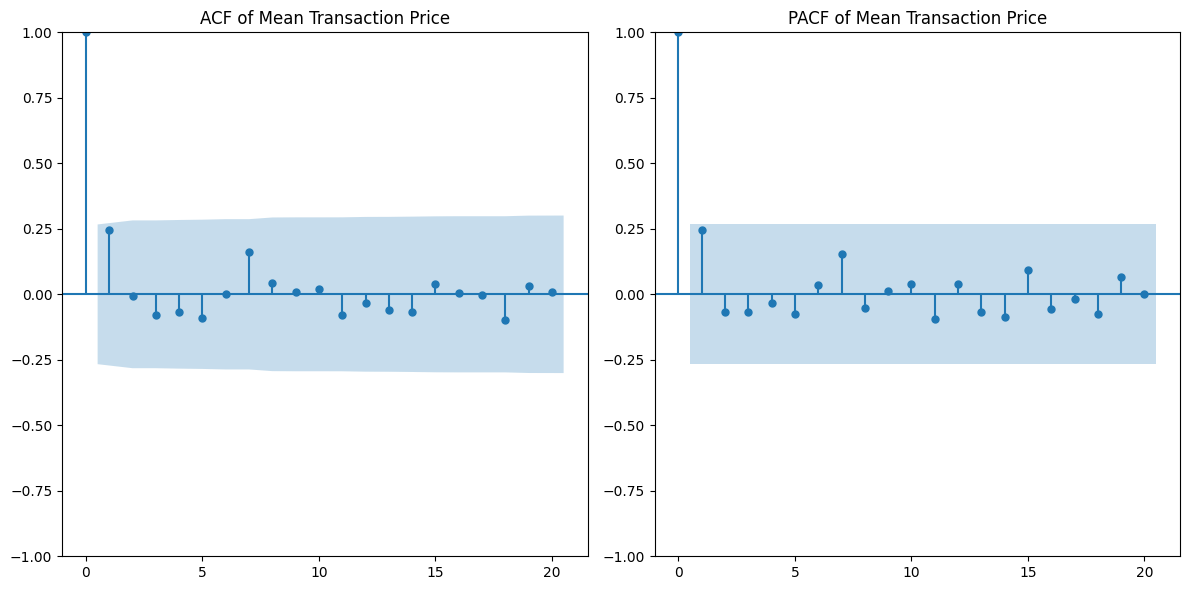

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.7923
p-value: 0.0001
Critical Values:
   1%: -3.5602
   5%: -2.9179
   10%: -2.5968

Interpretation:
The time series is stationary (p-value < 0.05, reject null hypothesis).




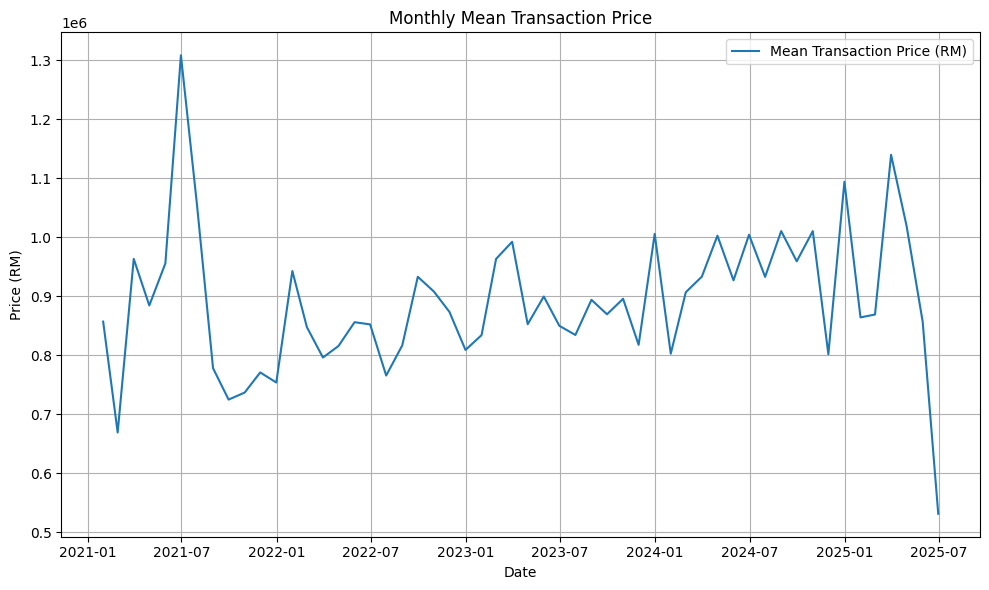

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller # Import adfuller

# Load the prepared time series
try:
    df = pd.read_csv('arima_ready_data.csv')
except FileNotFoundError:
    print("Error: 'arima_ready_data.csv' not found. Please run the previous script to generate it.")
    exit()

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(df['TransactionPrice'], lags=20, ax=plt.gca(), title='ACF of Mean Transaction Price')
plt.subplot(122)
plot_pacf(df['TransactionPrice'], lags=20, ax=plt.gca(), title='PACF of Mean Transaction Price')
plt.tight_layout()
plt.savefig('acf_pacf_plots.png')
plt.show()

# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df['TransactionPrice'])

print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
print("Critical Values:")
for key, value in adf_result[4].items():
    print(f"   {key}: {value:.4f}")
print("\nInterpretation:")
if adf_result[1] < 0.05:
    print("The time series is stationary (p-value < 0.05, reject null hypothesis).")
else:
    print("The time series is non-stationary (p-value >= 0.05, fail to reject null hypothesis).")
print("\n")

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TransactionPrice'], label='Mean Transaction Price (RM)') # Use df.index
plt.title('Monthly Mean Transaction Price')
plt.xlabel('Date')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


ARIMA(1,0,1) Model Performance Metrics:
R-squared (R²): 0.0747
RMSE (RM): 115920.82

Forecast for Next 6 Months with Confidence Intervals:
                 Date  Forecasted Price       Lower CI      Upper CI
2025-07-31 2025-07-31     783913.145277  558928.518205  1.008898e+06
2025-08-31 2025-08-31     878169.076249  643038.106022  1.113300e+06
2025-09-30 2025-09-30     888559.856109  653308.270080  1.123811e+06
2025-10-31 2025-10-31     889705.336345  654452.284868  1.124958e+06
2025-11-30 2025-11-30     889831.614160  654578.544874  1.125085e+06
2025-12-31 2025-12-31     889845.535034  654592.465532  1.125099e+06


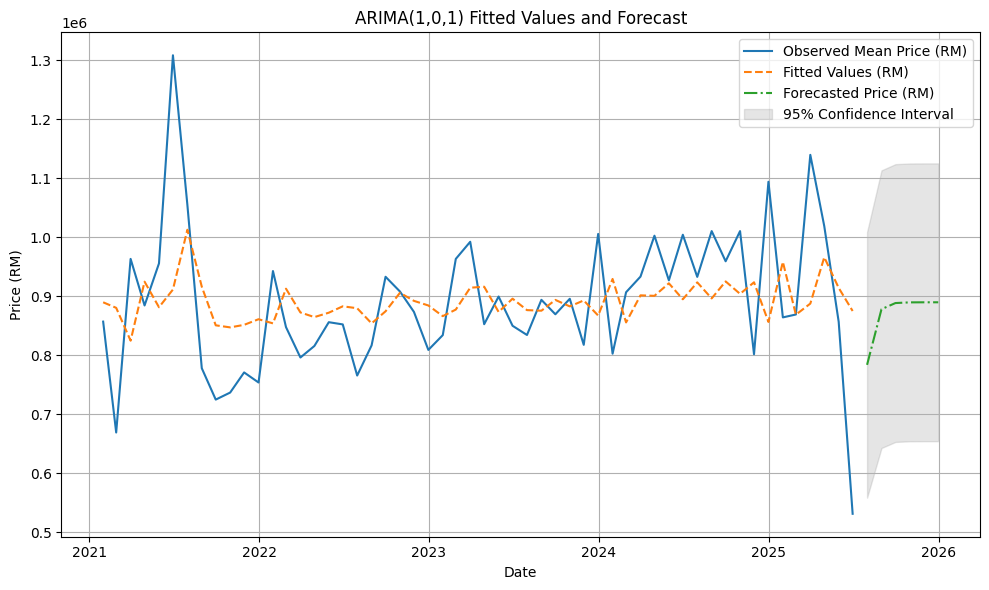

Results saved to 'arima_metrics_results.txt' and 'arima_forecast.csv'. Plot saved as 'arima_metrics_plot.png'.


In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import r2_score, mean_squared_error

# Load the prepared time series
try:
    df = pd.read_csv('arima_ready_data.csv')
except FileNotFoundError:
    print("Error: 'arima_ready_data.csv' not found. Please run the previous script to generate it.")
    exit()

# Convert Date to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Fit ARIMA(1,0,1) model
try:
    model = ARIMA(df['TransactionPrice'], order=(1, 0, 1))
    model_fit = model.fit()
except Exception as e:
    print(f"Error fitting ARIMA model: {e}")
    exit()

# Get in-sample predictions
predictions = model_fit.fittedvalues

# Calculate R-squared
r2 = r2_score(df['TransactionPrice'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(df['TransactionPrice'], predictions))

# Print metrics
print("ARIMA(1,0,1) Model Performance Metrics:")
print(f"R-squared (R²): {r2:.4f}")
print(f"RMSE (RM): {rmse:.2f}")

# Forecast for 6 months ahead (to match previous output)
forecast_steps = 6
forecast_object = model_fit.get_forecast(steps=forecast_steps)
forecast = forecast_object.predicted_mean
conf_int = forecast_object.conf_int()

# Create forecast DataFrame
forecast_index = pd.date_range(start=df.index[-1] + pd.offsets.MonthEnd(1), periods=forecast_steps, freq='ME')
forecast_df = pd.DataFrame({
    'Date': forecast_index,
    'Forecasted Price': forecast.values,
    'Lower CI': conf_int.iloc[:, 0],
    'Upper CI': conf_int.iloc[:, 1]
})

print("\nForecast for Next 6 Months with Confidence Intervals:")
print(forecast_df)

# Plot observed data, predictions, and forecast
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['TransactionPrice'], label='Observed Mean Price (RM)')
plt.plot(df.index, predictions, label='Fitted Values (RM)', linestyle='--')
plt.plot(forecast_df['Date'], forecast_df['Forecasted Price'], label='Forecasted Price (RM)', linestyle='-.')
plt.fill_between(forecast_df['Date'], forecast_df['Lower CI'], forecast_df['Upper CI'], color='gray', alpha=0.2, label='95% Confidence Interval')
plt.title('ARIMA(1,0,1) Fitted Values and Forecast')
plt.xlabel('Date')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('arima_metrics_plot.png')
plt.show()

# Save results
with open('arima_metrics_results.txt', 'w') as f:
    f.write("ARIMA(1,0,1) Model Performance Metrics:\n")
    f.write(f"R-squared (R²): {r2:.4f}\n")
    f.write(f"RMSE (RM): {rmse:.2f}\n\n")
    f.write("Forecast for Next 6 Months with Confidence Intervals:\n")
    f.write(str(forecast_df) + "\n")
print("Results saved to 'arima_metrics_results.txt' and 'arima_forecast.csv'. Plot saved as 'arima_metrics_plot.png'.")
forecast_df.to_csv('arima_forecast.csv', index=False)


Error installing statsmodels: name 'subprocess' is not defined
✅ Data loaded successfully!

Historical Prices:
                Price  Y-o-Y %
Year                          
2010-01-01  243284.09    10.38
2011-01-01  276907.03    13.17
2012-01-01  322187.18    16.35
2013-01-01  365642.85    13.48
2014-01-01  396149.59     8.35
2015-01-01  427295.20     7.86
2016-01-01  464907.07     8.79
2017-01-01  493950.74     6.26
2018-01-01  491799.02    -0.45
2019-01-01  484802.06    -1.43
2020-01-01  492431.80     1.58
2021-01-01  502969.30     2.15
2022-01-01  530954.26     5.56
2023-01-01  554465.44     4.43
2024-01-01  572633.98     3.28

=== STATIONARITY TEST ===
{'ADF Statistic': -2.270373685140338, 'p-value': 0.1817011150698431, 'Stationary': np.False_}

ARIMA Performance (In-Sample):
Order: (1, 1, 1)
R-squared (R²): 0.9713
RMSE (RM): 14218.25

ARIMA LOOCV Performance:
R-squared (R²): 0.9533
RMSE (RM): 12605.39

Forecast for 2025–2026:
 Year  ARIMA Forecast  ARIMA Lower CI  ARIMA Upper CI  

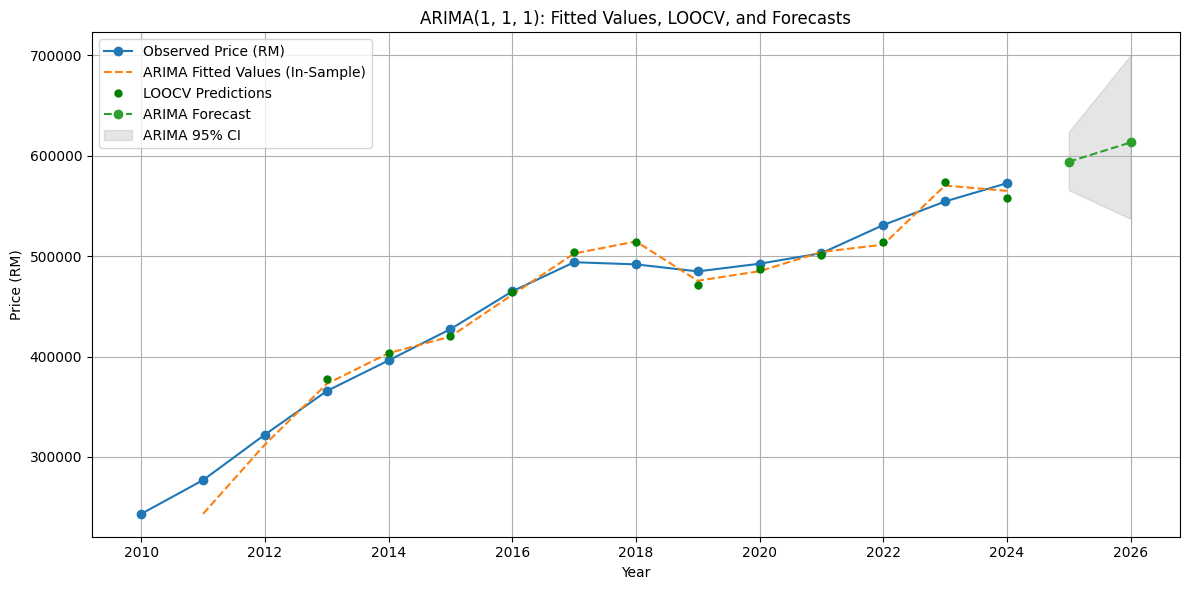

Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_squared_error
from io import StringIO # Import StringIO from io
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Install statsmodels
def install_package(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "--upgrade"])
        print(f"Successfully installed {package}")
    except Exception as e:
        print(f"Error installing {package}: {e}")

install_package("statsmodels")

# Load the annual dataset
data = """Year of Year,State,Type,Index Point,Price,Y-o-Y %
2010,Kuala Lumpur,High-rise,100,243284.085787671,10.375275938
2011,Kuala Lumpur,High-rise,113.171282974,276907.029001249,13.171282974
2012,Kuala Lumpur,High-rise,131.675,322187.18,16.350187557
2013,Kuala Lumpur,High-rise,149.425,365642.8475,13.480159484
2014,Kuala Lumpur,High-rise,161.9,396149.5925,8.348669901
2015,Kuala Lumpur,High-rise,174.625,427295.195,7.859789994
2016,Kuala Lumpur,High-rise,189.975,464907.0675,8.790264853
2017,Kuala Lumpur,High-rise,201.875,493950.74,6.263982103
2018,Kuala Lumpur,High-rise,200.975,491799.0225,-0.445820433
2019,Kuala Lumpur,High-rise,198.1,484802.06,-1.430526185
2020,Kuala Lumpur,High-rise,201.225,492431.795,1.577486118
2021,Kuala Lumpur,High-rise,205.55,502969.295,2.149335321
2022,Kuala Lumpur,High-rise,216.975,530954.265,5.563951970
2023,Kuala Lumpur,High-rise,226.575,554465.44,4.428097964
2024,Kuala Lumpur,High-rise,234,572633.985,3.277060576"""
df = pd.read_csv(StringIO(data))
df.rename(columns={'Year of Year': 'Year'}, inplace=True)
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.set_index('Year', inplace=True)

# No outlier detection to retain all 15 points
df_clean = df.copy()

# Log transformation
df_clean.loc[:, 'LogPrice'] = np.log(df_clean['Price'])

# Stationarity test
def stationarity_test(series):
    result = adfuller(series.dropna())
    return {
        'ADF Statistic': float(result[0]),
        'p-value': float(result[1]),
        'Stationary': result[1] <= 0.05
    }

print("✅ Data loaded successfully!")
print("\nHistorical Prices:")
print(df_clean[['Price', 'Y-o-Y %']].round(2))
print("\n=== STATIONARITY TEST ===")
print(stationarity_test(df_clean['Price']))

# LOOCV for ARIMA(1,1,1)
loocv_predictions = []
loocv_true_prices = []
min_train_size = 3

for i in range(1, len(df_clean)):  # Start from 2011
    train_indices = df_clean.index[:i]
    if len(train_indices) < min_train_size:
        continue
    test_index = df_clean.index[i]
    train_data = df_clean.loc[train_indices, 'LogPrice']
    test_price = df_clean['Price'].loc[test_index]
    last_train_price = df_clean['Price'].loc[train_indices[-1]]

    try:
        arima_order = (1, 1, 1)
        model = ARIMA(train_data, order=(1, 1, 1))
        model_fit = model.fit()
        pred = model_fit.forecast(steps=1)[0]
        pred_price = np.exp(np.clip(pred, np.log(1e-5), 20))
        if not np.isnan(pred_price) and pred_price > 0:
            loocv_predictions.append(pred_price)
            loocv_true_prices.append(test_price)
        else:
            print(f"Warning: Invalid prediction ({pred_price}) for fold {test_index.year}, using last training price")
            loocv_predictions.append(last_train_price)
            loocv_true_prices.append(test_price)
    except Exception as e:
        print(f"Warning: ARIMA failed for fold {test_index.year}. Error: {e}")
        loocv_predictions.append(last_train_price)
        loocv_true_prices.append(test_price)

# Calculate LOOCV metrics
r2_loocv = r2_score(loocv_true_prices, loocv_predictions)
rmse_loocv = np.sqrt(mean_squared_error(loocv_true_prices, loocv_predictions))

# Fit ARIMA(1,1,1) on full data
try:
    arima_order = (1, 1, 1)
    model = ARIMA(df_clean['LogPrice'], order=(1, 1, 1))
    model_fit = model.fit()
    fitted_log_prices = model_fit.fittedvalues
    fitted_prices = np.exp(np.clip(fitted_log_prices, np.log(1e-5), 20))
    r2_insample = r2_score(df_clean['Price'].iloc[1:], fitted_prices[1:])
    rmse_insample = np.sqrt(mean_squared_error(df_clean['Price'].iloc[1:], fitted_prices[1:]))
except Exception as e:
    print(f"Warning: ARIMA fitting failed on full data. Error: {e}")
    r2_insample, rmse_insample = np.nan, np.nan
    fitted_prices = np.full_like(df_clean['Price'], np.nan)

# Generate 2-year forecast
arima_forecast_object = model_fit.get_forecast(steps=2)
arima_forecast_mean = arima_forecast_object.predicted_mean
arima_conf_int = arima_forecast_object.conf_int()

# Apply clipping before exponentiating forecast and confidence intervals
arima_forecast_prices = np.exp(np.clip(arima_forecast_mean, np.log(1e-5), 20))
arima_lower_ci = np.exp(np.clip(arima_conf_int.iloc[:, 0], np.log(1e-5), 20))
arima_upper_ci = np.exp(np.clip(arima_conf_int.iloc[:, 1], np.log(1e-5), 20))

# Create forecast DataFrame with correct years (2025 and 2026)
forecast_years = [df_clean.index[-1].year + 1, df_clean.index[-1].year + 2]
forecast_df = pd.DataFrame({
    'Year': forecast_years,
    'ARIMA Forecast': arima_forecast_prices.round(0).astype(int),
    'ARIMA Lower CI': arima_lower_ci.round(0).astype(int),
    'ARIMA Upper CI': arima_upper_ci.round(0).astype(int)
})


# Calculate growth rates
last_price = df_clean['Price'].iloc[-1]
try:
    growth_2025 = ((forecast_df['ARIMA Forecast'].iloc[0] / last_price) - 1) * 100
    growth_2026 = ((forecast_df['ARIMA Forecast'].iloc[1] / forecast_df['ARIMA Forecast'].iloc[0]) - 1) * 100
except Exception:
    growth_2025, growth_2026 = np.nan, np.nan # Set to NaN if forecast is NaN
forecast_df['Growth_%'] = [growth_2025, growth_2026]


# Print performance metrics
print("\nARIMA Performance (In-Sample):")
print(f"Order: {arima_order}")
print(f"R-squared (R²): {r2_insample:.4f}")
print(f"RMSE (RM): {rmse_insample:.2f}")
print("\nARIMA LOOCV Performance:")
print(f"R-squared (R²): {r2_loocv:.4f}")
print(f"RMSE (RM): {rmse_loocv:.2f}")

print("\nForecast for 2025–2026:")
print(forecast_df.to_string(index=False))

# Plot observed data, fitted values, and forecasts
plt.figure(figsize=(12, 6))
plt.plot(df_clean.index, df_clean['Price'], label='Observed Price (RM)', marker='o')
plt.plot(df_clean.index[1:], fitted_prices[1:], label='ARIMA Fitted Values (In-Sample)', linestyle='--') # Corrected index for fitted values

# Create time index for LOOCV predictions
loocv_index = df_clean.index[len(df_clean) - len(loocv_predictions):]
plt.plot(loocv_index, loocv_predictions, 'go', markersize=5, label='LOOCV Predictions') # Plot LOOCV predictions

# Use the index from the ARIMA forecast object for plotting
arima_forecast_plot_index = arima_forecast_mean.index
plt.plot(arima_forecast_plot_index, arima_forecast_prices, label='ARIMA Forecast', linestyle='--', marker='o')
plt.fill_between(arima_forecast_plot_index, arima_lower_ci, arima_upper_ci, color='gray', alpha=0.2, label='ARIMA 95% CI')


plt.title(f'ARIMA{arima_order}: Fitted Values, LOOCV, and Forecasts')
plt.xlabel('Year')
plt.ylabel('Price (RM)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('mhpi_arima_model_plot.png')
plt.show()

# Save results
df_clean.to_csv('preprocessed_mhpi_data.csv')
with open('mhpi_arima_model_results.txt', 'w') as f:
    f.write("ARIMA Performance (In-Sample):\n")
    f.write(f"Order: {arima_order}\n")
    f.write(f"R-squared (R²): {r2_insample:.4f}\n")
    f.write(f"RMSE (RM): {rmse_insample:.2f}\n")
    f.write("\nARIMA LOOCV Performance:\n")
    f.write(f"R-squared (R²): {r2_loocv:.4f}\n")
    f.write(f"RMSE (RM): {rmse_loocv:.2f}\n")
    f.write("\nForecast for 2025–2026:\n")
    f.write(str(forecast_df.to_string(index=False)) + "\n") # Save as string without index
forecast_df.to_csv('mhpi_arima_forecast.csv', index=False)
print("Results saved to 'mhpi_arima_model_results.txt', 'preprocessed_mhpi_data.csv', and 'mhpi_arima_forecast.csv'. Plot saved as 'mhpi_arima_model_plot.png'.")

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression # Import LinearRegression

# # Load and preprocess data
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')
scheme_mean = df.groupby('SchemeName')['TransactionPrice'].mean().apply(np.log)
df['SchemeName_encoded'] = df['SchemeName'].map(scheme_mean)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], format='%b-%y', errors='coerce')
df = df.sort_values('TransactionDate')

# Prepare features and target
initial_features = ['ParcelArea', 'Level_numeric', 'Tenure_encoded', 'SchemeName_encoded']
X = df[initial_features]
y = np.log(df['TransactionPrice'].loc[X.index])

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']

# Handle missing values and outliers
X = X.fillna(0)
X = X.dropna()
y = y.loc[X.index] # Ensure y aligns with X after dropping NaNs

# Identify outliers using Linear Regression
X_with_const = np.c_[np.ones(X.shape[0]), X]
model_initial = LinearRegression().fit(X_with_const, y)
residuals = y - model_initial.predict(X_with_const)
outliers = residuals[abs(residuals) > 2 * residuals.std()].index

# Drop outliers from both X and y
X = X.drop(outliers)
y = y.drop(outliers)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
train_size = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# # Train Random Forest
# rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
# rf_model.fit(X_train, y_train)


import pickle
import os
from google.colab import drive

# Mount Google Drive to load the model and scaler
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

# Define the filenames for the saved model and scaler
model_filename = '/content/drive/MyDrive/saved_models/random_forest_best_model.pkl'
scaler_filename = '/content/drive/MyDrive/saved_models/scaler.pkl'

# Load the trained model
loaded_rf_model = None # Initialize to None
try:
    with open(model_filename, 'rb') as file:
        loaded_rf_model = pickle.load(file)
    print(f"Random Forest model loaded successfully from {model_filename}")
except FileNotFoundError:
    print(f"Error: Model file not found at {model_filename}. Please make sure the model was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the model: {e}")

# Load the fitted scaler
scaler = None # Initialize to None
try:
    with open(scaler_filename, 'rb') as file:
        scaler = pickle.load(file)
    print(f"Scaler object loaded successfully from {scaler_filename}")
except FileNotFoundError:
    print(f"Error: Scaler file not found at {scaler_filename}. Please make sure the scaler was saved correctly.")
except Exception as e:
    print(f"An error occurred while loading the scaler: {e}")

# You can now use loaded_rf_model and scaler in subsequent cells or code within this cell
# For example, to check the type of the loaded objects:
if loaded_rf_model is not None:
    print(f"\nType of loaded model: {type(loaded_rf_model)}")
if scaler is not None:
    print(f"Type of loaded scaler: {type(scaler)}")


y_pred_rf = loaded_rf_model.predict(X_test)
rmse_rf_log = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_rf_orig = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_rf)))
r2_rf_best = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor with Best Parameters:")
print(f"Test RMSE (Log): {rmse_rf_log:.4f}")
print(f"Test RNSE (Ori): {rmse_rf_orig:.4f}")
print(f"Test R2: {r2_rf_best:.4f}")

/tmp/ipython-input-2051537017.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ParcelArea_sq'] = X['ParcelArea'] ** 2
/tmp/ipython-input-2051537017.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


Drive already mounted
Random Forest model loaded successfully from /content/drive/MyDrive/saved_models/random_forest_best_model.pkl
Scaler object loaded successfully from /content/drive/MyDrive/saved_models/scaler.pkl

Type of loaded model: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Type of loaded scaler: <class 'sklearn.preprocessing._data.StandardScaler'>
Random Forest Regressor with Best Parameters:
Test RMSE (Log): 0.1306
Test RNSE (Ori): 229183.0415
Test R2: 0.9673
